In [1]:
import numpy as np
import csv
import pandas as pd
import os
import torch
import matplotlib.pyplot as plt

In [2]:
import camera_tools as ct

In [3]:
from cmac2 import CMAC

In [4]:
#Calibrate the camera to detect green box, if you haven't done this calibration before
low_green, high_green = ct.colorpicker()
print(low_green)
print(high_green)

[51 70 93]
[120 103 208]


In [148]:
low_red, high_red = ct.colorpicker()
print(low_red)
print(high_red)

[0 0 0]
[255 255 255]


In [5]:
#Check whether the camera detects the green object properly
cam = ct.prepare_camera()
image = ct.capture_image(cam)
x,y = ct.locate(image, low_green, high_green)
ct.show_camera(cam)

print(x,y)

None None


In [ ]:
#Check whether the camera detects the green object properly
cam_red = ct.prepare_camera()
img_red = ct.capture_image(cam_red)
ct.show_camera(cam_red, low_red, high_red)

In [6]:
from FableAPI.fable_init import api
api.setup(blocking=True)

PORT: COM3, NAME: Standard Serial over Bluetooth link (COM3), HWID: BTHENUM\{00001101-0000-1000-8000-00805F9B34FB}_VID&0001005D_PID&223B\7&30FFFDFE&1&1C52169F0364_C00000000
PORT: COM4, NAME: Standard Serial over Bluetooth link (COM4), HWID: BTHENUM\{00001101-0000-1000-8000-00805F9B34FB}_LOCALMFG&0000\7&30FFFDFE&1&000000000000_00000000
PORT: COM5, NAME: USB Serial Device (COM5), HWID: USB VID:PID=03EB:FABE SER= LOCATION=1-1
Trying to connect COM5 dongle connect: True
Dongle...success
setup done


True

In [16]:
moduleids = api.discoverModules()
print("Module IDs: ", moduleids)
moduleID = moduleids[0]
print("Battery level:",api.getBattery(moduleID),"%")

Module IDs:  ['5YA ']
Battery level: 100 %


In [18]:
api.setPos(-90,0,moduleID)

0

In [19]:
#Create two files (if they were not already created) to collect data.
if (not os.path.exists("xycoords_2.csv")):
    f = open('xycoords_2.csv', 'w')
    with f:
        writer = csv.writer(f)
        writer.writerows([["X","Y"]])
    f.close()
if (not os.path.exists("angles_2.csv")):
    f = open('angles_2.csv','w')
    with f:
        writer = csv.writer(f)
        writer.writerows([["Y_angle"]])
    f.close()

In [20]:
#we use the collectData function to collect the data for training.
    #we collect Y (angular) position of the end effector
    #we collect x,y coordinates of the end effector in the camera image
    #see the video final_project_guidance.mp4
def collectData(desired_angle_change):
    cam = ct.prepare_camera()
    ct.show_camera(cam)
    cam.release()
    cam = ct.prepare_camera()
    api.setPos(-90,90,moduleID)
    api.sleep(1.5)
    Y_angle_list = []
    XY_coordinates_list = []
    traversed_directions = 0
    current_direction = 0     # 1 is for clockwise, 0 is for anticlockwise
    traversedDirections = 0
    num_of_iterations = (int)(np.round(360/desired_angle_change,1))
    #Fable's Y arm traverse anticlockwise
    if current_direction == 0:
        for i in range(num_of_iterations):
            img = ct.capture_image(cam)
            x,y = ct.locate(img, low_green, high_green)
            currentRobotYAng = (int)(np.round(api.getPos(1,moduleID),1))
            Y_angle_list.append([currentRobotYAng])
            XY_coordinates_list.append([x,y])
            currentRobotYAng = currentRobotYAng - (desired_angle_change)
            api.setPos(-90,currentRobotYAng,moduleID)
            api.sleep(1.5)
            if np.abs(currentRobotYAng) > 90:
                current_direction = 1
                traversedDirections = traversedDirections + 1
                break
    #Fable's Y Arm traverses clockwise
    if current_direction == 1:
        for i in range(num_of_iterations):
            img = ct.capture_image(cam)
            x,y = ct.locate(img, low_green, high_green)
            currentRobotYAng = (int)(np.round(api.getPos(1,moduleID),1))
            Y_angle_list.append([currentRobotYAng])
            XY_coordinates_list.append([x,y])
            currentRobotYAng = currentRobotYAng + (desired_angle_change)
            api.setPos(-90,currentRobotYAng,moduleID)
            api.sleep(1.5)
            if np.abs(currentRobotYAng) > 90:
                current_direction = 0
                traversedDirections = traversedDirections + 1
                break
    if traversedDirections == 2:
        cam.release()
        #Save collected data to files
        y_angle_file_ptr = open('angles_2.csv', 'a+', newline ='')
        with y_angle_file_ptr:
            writer = csv.writer(y_angle_file_ptr)
            writer.writerows(Y_angle_list)
        y_angle_file_ptr.close()
        file_xycoords = open('xycoords_2.csv', 'a+', newline ='')
        with file_xycoords:
            writer = csv.writer(file_xycoords)
            writer.writerows(XY_coordinates_list)
        file_xycoords.close()
    return
    

In [21]:
#TODO: Call the CollectData() function with different values for 'desired_angle_change' argument and collect sufficient
#sufficient amout of data to angles_2.csv file and xycoords_2.csv file.
collectData(5)

In [22]:
#Use this function to calculate Y (angular) position errors 
# Y (angular) positions
def readAngleFilesAndCollectErrors(fileName):
    angleDataFrame = pd.read_csv(fileName)
    desired_column = angleDataFrame.columns[0]
    angle_error_list = []
    for i in range(1,len(angleDataFrame)):
        current_data_element = angleDataFrame[desired_column][i]
        previous_data_element = angleDataFrame[desired_column][i-1]
        #TODO: Calculate the Y (angular) position error(say current_error) as the difference between 
        # the current Y (angular) position and previous Y (angular) position
        current_error = current_data_element - previous_data_element
        #print(current_data_element," ", previous_data_element, " ", current_error)
        angle_error_list = angle_error_list + [current_error]
    return angle_error_list

In [23]:
#Use this function to calculate errors between x and y coordinates
def readXYCoordsFilesAndCollectErrors(fileName):
    xyCoordsDataFrame = pd.read_csv(fileName)
    x_col_name = xyCoordsDataFrame.columns[0]
    y_col_name = xyCoordsDataFrame.columns[1]
    x_pos_error_list = []
    y_pos_error_list = []
    for i in range(1,len(xyCoordsDataFrame)):
        current_data_element_x = xyCoordsDataFrame[x_col_name][i]
        current_data_element_y = xyCoordsDataFrame[y_col_name][i]
        previous_data_element_x = xyCoordsDataFrame[x_col_name][i-1]
        previous_data_element_y = xyCoordsDataFrame[y_col_name][i-1]
        error_x_pos = current_data_element_x - previous_data_element_x 
        error_y_pos = current_data_element_y - previous_data_element_y
        x_pos_error_list = x_pos_error_list + [error_x_pos]
        y_pos_error_list = y_pos_error_list + [error_y_pos] 
    return [x_pos_error_list,y_pos_error_list]

In [36]:
#Read the provided files and load the calculated errors into to appropriate lists as follows
# angle_error_list_1 = readAngleFilesAndCollectErrors("angles_1.csv")
# x_pos_error_list_1,y_pos_error_list_1 = readXYCoordsFilesAndCollectErrors("xyCoords_1.csv")
#Read the files with the data dumped by you and load the calculated errors into appropriate lists.
angle_error_list_2 = readAngleFilesAndCollectErrors("angles_2.csv")
x_pos_error_list_2,y_pos_error_list_2 = readXYCoordsFilesAndCollectErrors("xyCoords_2.csv")

Remove any nans

In [37]:
x_coord_error_array = np.array(x_pos_error_list_2)
y_coord_error_array = np.array(y_pos_error_list_2)
angle_error_array = np.array(angle_error_list_2)
print("Angle errors: ",angle_error_array.shape)
print("X position errors: ",x_coord_error_array.shape)
print("Y position errors: ",y_coord_error_array.shape)

Angle errors:  (83,)
X position errors:  (83,)
Y position errors:  (83,)


In [38]:
# Get a boolean mask where True indicates the location of NaNs in angle_error_array
nan_mask = np.isnan(x_coord_error_array)

# Use this mask to remove corresponding elements from x_coord_error_array and y_coord_error_array
x_coord_error_array = x_coord_error_array[~nan_mask]
y_coord_error_array = y_coord_error_array[~nan_mask]

# Now remove the NaNs from angle_error_array
angle_error_array = angle_error_array[~nan_mask]

print(angle_error_array.shape, x_coord_error_array.shape, y_coord_error_array.shape)

(82,) (82,) (82,)


Merge them

In [39]:
# Here we use 80% of the collected data  as the training set and 20% of the collected data as test set.
#TODO: Assign different propotions of the collected data set and test set and check how the test set error varies of the 
#Neural Network
data =  np.vstack((x_coord_error_array,y_coord_error_array)).T
target = np.vstack(angle_error_array)
data_input_tensor = torch.tensor(data.tolist()).float()
data_target_tensor = torch.tensor(target.tolist()).float()
data_with_target = torch.cat((data_input_tensor,data_target_tensor),1)
#TODO: what is the importance of using DataLoader utility function here?
loader= torch.utils.data.DataLoader(data_with_target,
                                     batch_size=data_with_target.size()[0], shuffle=True,
                                     num_workers=0)
#training set
train_set = []
#test set
test_set = []
for i in iter(loader):
    train_set_index = (int)(np.round(i.shape[0]*0.8))
    train_set = i[:train_set_index,:]
    test_set = i[train_set_index:,:]

In [40]:
print(train_set.shape)
print(test_set.shape)

torch.Size([66, 3])
torch.Size([16, 3])


In [41]:
#Defining Neural Network Model
class NN(torch.nn.Module):
    def __init__(self,n_feature,n_hidden1,n_hidden2,n_output):
        super(NN,self).__init__()
        self.hidden1 = torch.nn.Linear(n_feature,n_hidden1)
        #self.do1 = torch.nn.Dropout(0.15)
        #self.relu1 = torch.nn.LeakyReLU()
        #self.bn1 = torch.nn.BatchNorm1d(n_hidden1,affine=False)
        self.hidden2 = torch.nn.Linear(n_hidden1,n_hidden2)
        #self.bn2 = torch.nn.BatchNorm1d(n_hidden2,affine=False)
        #self.relu2 = torch.nn.LeakyReLU()
        #self.do2 = torch.nn.Dropout(0.1)
        self.predict = torch.nn.Linear(n_hidden2,n_output)
        
        
    def forward(self,x):
        x = self.hidden1(x)
        x = torch.sigmoid(x)
        #x = self.do1(x)
        x = self.hidden2(x)
        x = torch.sigmoid(x)
        #x = self.do2(x)
        x = self.predict(x)
        return x

In [42]:
#instantiate the Neural Network
#model = NN(n_feature=2,n_hidden1=17,n_hidden2=7, n_output=1)
model = NN(n_feature=2,n_hidden1=100,n_hidden2=100, n_output=1)

In [43]:
#Define loss function : 
# here we use Mean Square Error as the loss function
loss_func = torch.nn.MSELoss()

In [44]:
#Define the optimizer that should be used in training the Neural Network.
# Here 'lr' is the learning rate
optimizer = torch.optim.Adam(model.parameters(),lr=0.01)

In [45]:
train_set_inputs = train_set[:,:2]
#TODO: calculate the mean value of the train_set_inputs. 
mean_of_train_input = torch.mean(train_set_inputs,0)
#standard deviation of the train set inputs.
std_of_the_train_input = torch.std(train_set_inputs,0)
#here we normalize the inputs of the neural network. What is the importance of that?
normalized_train_set_inputs = (train_set_inputs - mean_of_train_input)/std_of_the_train_input

In [46]:
#targets of the training set
train_set_targets = train_set[:,2][:,np.newaxis]

In [47]:
print(normalized_train_set_inputs.shape)
print(train_set_targets.shape)

torch.Size([66, 2])
torch.Size([66, 1])


In [48]:
#TODO: train the Neural network model by changing the hyper parameters such as learning rate, number of epochs, number of neurons in hidden layers of the neural network.
# What is the minimum mean square error that you can achieve as your neural network converges for the training set.
#  (you will be able to achive a MSE of less than 10 as the Neural network converges.)
num_epochs = 2000
losslist = []
for _ in range(num_epochs):
    with torch.autocast(device_type="cpu", dtype=torch.bfloat16):
        prediction = model(normalized_train_set_inputs) # Forward pass prediction. Saves intermediary values required for backwards pass
        loss = loss_func(prediction, train_set_targets) # Computes the loss for each example, using the loss function defined above
    optimizer.zero_grad() # Clears gradients from previous iteration
    loss.backward() # Backpropagation of errors through the network
    optimizer.step() # Updating weights
    # print("prediction =",prediction)
    # print("Loss: ", loss.detach().numpy())
    losslist.append(loss.detach().numpy())

In [ ]:
print("Loss: ", losslist)

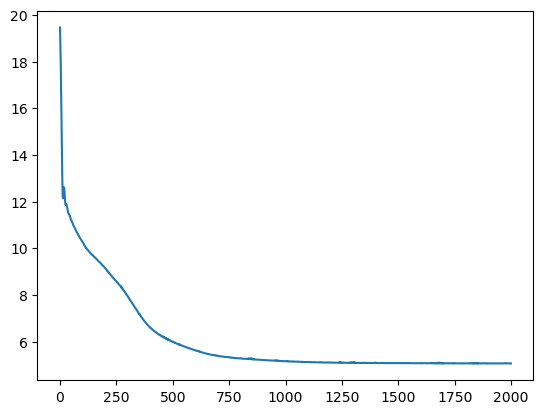

In [49]:
#plot the mean square error in each epoch/iteration
plt.plot(np.arange(len(losslist)),losslist)
plt.show()

In [50]:
#save the best neural network model you have obtained.
torch.save(model.state_dict(), 'best_nn_model.pth')

#Save the mean and standard deviation of the train set inputs because we need to use them at test time.

In [51]:
#reload the your best neural network model with saved parameters
model = NN(n_feature=2,n_hidden1=100,n_hidden2=100, n_output=1)
model.load_state_dict(torch.load('best_nn_model.pth'))

<All keys matched successfully>

In [52]:
#TODO: Extract inputs of the test_set
test_set_inputs = test_set[:,:2]
#TODO: Extract test set targets from the test_set
test_set_targets = test_set[:,2][:,np.newaxis]
print(test_set_inputs)

tensor([[ 20.,  -2.],
        [  0.,   0.],
        [  0.,  -2.],
        [ -3.,   1.],
        [-27.,   2.],
        [-10.,   0.],
        [-20.,   2.],
        [  0.,   0.],
        [-15.,   0.],
        [  7.,   0.],
        [  4.,   0.],
        [ -8.,   2.],
        [  0.,   1.],
        [  7.,  -1.],
        [  2.,   0.],
        [ -7.,   1.]])


In [53]:
#TODO: Normalize test set inputs by using the mean and standard deviation of the inputs of the training set
normalized_test_set_inputs = (test_set_inputs - mean_of_train_input)/std_of_the_train_input
# print(normalized_test_set_inputs)

tensor([[ 1.1976, -2.2343],
        [-0.0491,  0.1064],
        [-0.0491, -2.2343],
        [-0.2361,  1.2768],
        [-1.7322,  2.4471],
        [-0.6725,  0.1064],
        [-1.2959,  2.4471],
        [-0.0491,  0.1064],
        [-0.9842,  0.1064],
        [ 0.3872,  0.1064],
        [ 0.2002,  0.1064],
        [-0.5478,  2.4471],
        [-0.0491,  1.2768],
        [ 0.3872, -1.0640],
        [ 0.0756,  0.1064],
        [-0.4855,  1.2768]])


In [54]:
#TODO: feed the normalized test set inputs to the Neural Network model and obtain the prediction for the test set.
prediction_test = model(normalized_test_set_inputs)

In [55]:
print(prediction_test.shape)

torch.Size([16, 1])


tensor([[-6.6209],
        [ 1.4833],
        [ 0.5259],
        [ 5.0637],
        [ 0.4135],
        [ 4.1329],
        [ 4.1863],
        [ 1.4833],
        [ 0.5290],
        [-5.2244],
        [ 1.4476],
        [ 5.3167],
        [-6.0812],
        [-6.3278],
        [ 2.0111],
        [ 4.9987]], grad_fn=<AddmmBackward0>)


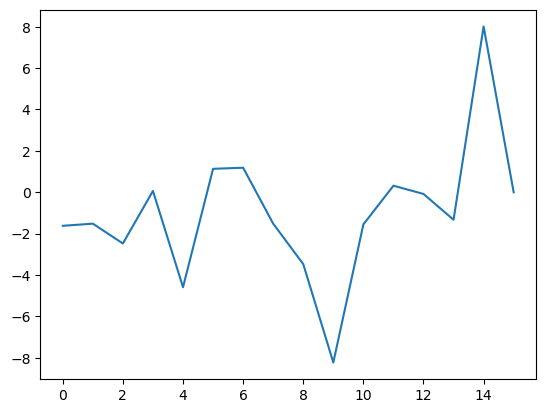

In [56]:
#plot the prediction error of the test set
test_set_prediction_error = prediction_test - test_set_targets
# print(prediction_test)
plt.plot(np.arange(len(test_set_prediction_error.tolist())),test_set_prediction_error.tolist())

In [ ]:
# In the example model trained with about 600 data, from a test set of 165 samples,
# 159 samples are predicted with prediction error less than 10.

In [ ]:
#TODO: Based on the prediction error of the test set, you can try to train the neural network again by changing the hyper parameters mentioned above.
# Also Try to add Dropout layers to the Neural network and check whether test prediction errors can be reduced further.

# DETECTING THE OBJECT AT TESTING PHASE

In [114]:
A = 130
T = 200

In [115]:
api.setPos(-90,90,moduleID)

0

In [70]:
#TODO: Detect the target object and obtain the coordinates of the object in the image
cam = ct.prepare_camera()
img = ct.capture_image(cam)
# ct.show_camera(cam, low_green, high_green)
x,y = ct.locate(img, low_green, high_green)
print(x,y)
target_x = x
target_y = y
# print("target_x = ",target_x)
# print("target_y = ",target_y)

365 198


In [128]:
api.setPos(-90,0,moduleID)

0

[12.0, 0.0]
[-3.9166013198433234, 0.0]
[12.162767538810726, 0.0]
[0.23408073140683427, 0.0]
[2.2933203633595554, 0.0]
[12.336480455230003, 0.0]
[4.3595708961441915, 0.0]
[6.358621381550506, 0.0]
[-5.670314668568892, 0.0]
[-1.7311562149001816, 0.0]
[16.17220926874313, 0.0]
[8.035929631887882, 0.0]
[-3.1438081509918447, 0.0]
[11.629225782521473, 0.0]
[3.3513079034594284, 0.0]
[15.018764966141077, 0.0]
[0.6279776332229972, 0.0]
[-5.8246159524517225, 0.0]
[-2.34251665273041, 0.0]
[13.07083912077701, 0.0]
[4.412082798021515, 0.0]
[-4.322083025113045, 0.0]
[16.865118667329625, 0.0]
[21.970542492074742, 0.0]
[22.99112377072953, 0.0]
[21.92388155425118, 0.0]
[22.765921564783525, 0.0]
[23.514439051959698, 0.0]
[12.16672156085258, 0.0]
[0.7201516088397284, 0.0]
[-10.827790731256869, 0.0]
[-0.47952534430697824, 0.0]
[9.762630315261958, 0.0]
[7.89646351051266, 0.0]
[-2.080131594297711, 0.0]
[10.830848144487845, 0.0]
[1.627516820582514, 0.0]
[-0.6918986610824618, 0.0]
[8.870943165472681, 0.0]
[6.31

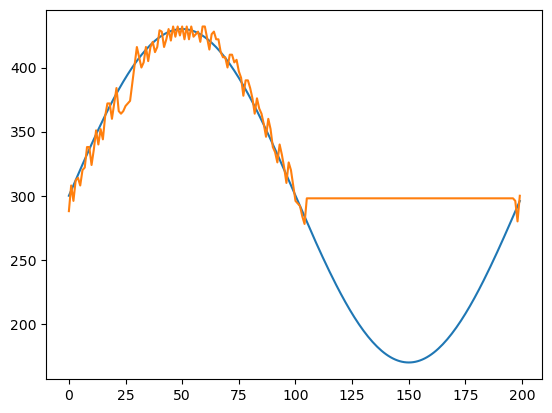

In [129]:
#Here we implement the control loop which is having Neural Network as the controller.
#In this case we donot integrate CMAC to the control loop
def ControlLoopWithNNWithoutCMAC(target__x_coordinate,target__y_coordinate):


    x_ref_vec = []
    x_act_vec = []

    number_of_iterations_for_convergence = 0
    #TODO:Intialize your best neural network model and load the saved paramemeters
    NN_model = NN(n_feature=2,n_hidden1=100,n_hidden2=100, n_output=1)
    NN_model.load_state_dict(torch.load('best_nn_model.pth'))
    
    #Here we loop for 50 iterations assuming that 
    # the controller should achieve the desired target within atmost 50 iterations
    for i in range(200):
        cam = ct.prepare_camera()
        img = ct.capture_image(cam)
        x,y = ct.locate(img,low_green, high_green)

        # cam_red = ct.prepare_camera()
        # img_red = ct.capture_image(cam)
        # x_red,y_red = ct.locate(img,low_red, high_red)

        # print(x,y)

        x_ref = A * np.sin(2*np.pi * i/T) + 300
        # x_ref = 450
        y_ref = y

        x_ref_vec.append(x_ref)
        x_act_vec.append(x)

        # print(i, x, x_ref)

        x_ref = float(x_ref)
        y_ref = float(y_ref)

        robot_x_coord_in_image = x
        robot_y_coord_in_image = y
        x_coord_error = x_ref - robot_x_coord_in_image;
        y_coord_error = y_ref - robot_y_coord_in_image;

        #Here if the errors are less than twenty pixels we assume robot reaches the target. 
        # However you can choose any reasonable threshold value instead of 20.
        # if (np.abs(x_coord_error) < (1+x_prev*1.02) and np.abs(y_coord_error) < (1+y_coord_error*1.02)):
        #     print("number of iterations for convergence = ", number_of_iterations_for_convergence)
        #     break

        xy_input_nn_model = [x_coord_error, y_coord_error]
        # print(xy_input_nn_model)
        
        #TODO: normalize the input to the Neural network model using meaning and variance of the training set inputs.
        normalize_xy_input_nn_model = (torch.tensor(xy_input_nn_model) - mean_of_train_input)/std_of_the_train_input

        prediction_for_Y_pos_increment = NN_model(normalize_xy_input_nn_model)

        #TODO: Get the current Y (angular) position/angle of the robot. you can use the api.getPos function of fable
        robot_current_Y_pos = api.getPos(1,moduleID)
        #Next Y angular position of the robot will be robot_Y_pos + prediction_for_Y_pos_increment
        robot_next_Y_pos = robot_current_Y_pos + prediction_for_Y_pos_increment
        # print(robot_next_Y_pos)
        #TODO: Set the next position of the robot to (-90,robot_next_Y_pos) using the setPos function of the fable.
        api.setPos(-90,robot_next_Y_pos,moduleID)
        api.sleep(0.3)
        number_of_iterations_for_convergence = number_of_iterations_for_convergence + 1

    return [x_ref_vec,x_act_vec]

#TODO: Call the control loop for a target which is detected. Record the number of iterations that the control loop spent for convergence.
[x_ref_vec, x_act_vec] = ControlLoopWithNNWithoutCMAC(target_x,target_y)
#TODO: change your target location and try again. You may change the target 4-5 times and check how the control loop work.
#Record the number of iterations that the control loop spent for convergence.
plt.plot(np.arange(len(x_ref_vec)),x_ref_vec)
plt.plot(np.arange(len(x_act_vec)),x_act_vec)
plt.show()

In [146]:
api.setPos(-90,90,moduleID)

0

In [147]:
#Now integrate the CMAC to the previous control loop which had only the Neural Network. 
#The implementation of the CMAC can be found in code given for second week exercises.
#TODO: Implement the control loop with both neural network and CMAC. 
def ControlLoopWithBothNNandCMAC(target_x, target_y, iter_num):
    
    # api.setPos(-90,0,moduleID)
    target_x_coord = target_x
    target_y_coord = target_y

    x_ref_vec = []
    x_act_vec = []

    number_of_iterations_for_convergence = 0
    max_iter = iter_num
    #TODO:Intialize your best neural network model and load the saved paramemeters
    NN_model = NN(n_feature=2,n_hidden1=100,n_hidden2=100, n_output=1)
    NN_model.load_state_dict(torch.load('best_nn_model.pth'))

    ## TODO: CMAC initialization
    n_rfs = 1
    beta = 0.01

    xmin = [152,152]
    xmax = [448, 448]

    c = CMAC(n_rfs, xmin, xmax, beta)

    ## Simulation loop
    for i in range(max_iter):
       
        cam = ct.prepare_camera()
        img = ct.capture_image(cam)
        x,y = ct.locate(img,low_green, high_green)

        # cam_red = ct.prepare_camera()
        # img_red = ct.capture_image(cam)
        # x_red,y_red = ct.locate(img,low_red, high_red)

        # x_ref = A * np.sin(2*np.pi * i/T) + 300
        x_ref = 450
        y_ref = y

        x_ref = float(x_ref)
        y_ref = float(y_ref)

        print(i, x, x_ref)

        x_ref_vec.append(x_ref)
        x_act_vec.append(x)

        # print(x,y)
        robot_x_coord_in_image = x
        robot_y_coord_in_image = y
        x_coord_error = x_ref - robot_x_coord_in_image;
        y_coord_error = y_ref - robot_y_coord_in_image;
        
        ## TODO: Implement the CMAC controller into the loop
        x_cmac = [x_ref ,robot_x_coord_in_image]
        angle_cmac = c.predict(x_cmac)

        # print(x_cmac)        
    
        #Here if the errors are less than twenty pixels we assume robot reaches the target. 
        # However you can choose any reasonable threshold value instead of 20.
        # if (np.abs(x_coord_error) < (1+x_prev*1.02) and np.abs(y_coord_error) < (1+y_coord_error*1.02)):
        #     print("number of iterations for convergence = ", number_of_iterations_for_convergence)
        #     break
        
        xy_input_nn_model = [x_coord_error,y_coord_error]
       
        #TODO: normalize the input to the Neural network model using meaning and variance of the training set inputs.
        normalize_xy_input_nn_model = (torch.tensor(xy_input_nn_model) - mean_of_train_input)/std_of_the_train_input
    
        prediction_for_Y_pos_increment = NN_model(normalize_xy_input_nn_model)
       
        #TODO: Get the current Y (angular) position/angle of the robot. you can use the api.getPos function of fable
        robot_current_Y_pos = api.getPos(1,moduleID)
        #Next Y angular position of the robot will be robot_Y_pos + prediction_for_Y_pos_increment
        robot_next_Y_pos = robot_current_Y_pos + prediction_for_Y_pos_increment
        
        c.learn(robot_next_Y_pos.detach().numpy())
        # print(angle_cmac)
        robot_nn_and_cmac = robot_next_Y_pos + angle_cmac

        #TODO: Set the next position of the robot to (-90,robot_next_Y_pos) using the setPos function of the fable.
        api.setPos(-90,robot_nn_and_cmac,moduleID)
        api.sleep(0.3)
        number_of_iterations_for_convergence = number_of_iterations_for_convergence + 1

    return [x_ref_vec,x_act_vec]

[x_ref_vec,x_act_vec] = ControlLoopWithBothNNandCMAC(0,0, 200)
plt.plot(np.arange(len(x_ref_vec)),x_ref_vec)
plt.plot(np.arange(len(x_act_vec)),x_act_vec)
plt.show()

d:\visualstudio\Bioinspired_Marcel\Bioinspired-Marcel\Final_project\cmac2.py:16: RuntimeWarning: divide by zero encountered in scalar divide
  self.sigma[k] = 0.5/np.sqrt(-np.log(crossval)) * (xmax[k] - xmin[k])/(self.n_rfs-1) # RFs cross at phi = crossval


0 138 450.0
1 136 450.0
2 136 450.0
3 138 450.0
4 136 450.0
5 136 450.0
6 137 450.0
7 140 450.0
8 140 450.0
9 140 450.0
10 140 450.0
11 140 450.0
12 140 450.0
13 139 450.0
14 140 450.0
15 140 450.0
16 138 450.0
17 138 450.0
18 136 450.0
19 136 450.0
20 138 450.0
21 136 450.0
22 136 450.0
23 136 450.0
24 138 450.0
25 140 450.0
26 140 450.0
27 140 450.0
28 140 450.0
29 140 450.0
30 140 450.0
31 140 450.0
32 140 450.0
33 140 450.0
34 140 450.0
35 140 450.0
36 140 450.0
37 140 450.0
38 140 450.0
39 140 450.0
40 140 450.0
41 140 450.0
42 140 450.0
43 140 450.0
44 140 450.0
45 140 450.0
46 140 450.0
47 140 450.0
48 140 450.0
49 140 450.0
50 140 450.0
51 140 450.0
52 140 450.0
53 140 450.0
54 140 450.0
55 140 450.0
56 140 450.0
57 140 450.0
58 140 450.0
59 140 450.0
60 140 450.0
61 140 450.0
62 140 450.0
63 140 450.0
64 137 450.0
65 138 450.0
66 136 450.0
67 137 450.0
68 137 450.0
69 137 450.0
70 137 450.0
71 137 450.0
72 137 450.0
73 137 450.0
74 138 450.0
75 137 450.0
76 138 450.0
77 138 45

KeyboardInterrupt: 

In [138]:
api.setPos(-90,0,moduleID)

0

0 278 300.0
1 282 304.0833986801567
2 284 308.1627675388107
3 304 312.23408073140683
4 316 316.29332036335956
5 320 320.33648045523
6 322 324.3595708961442
7 314 328.3586213815505
8 328 332.3296853314311
9 330 336.2688437850998
10 346 340.17220926874313
11 346 344.0359296318879
12 334 347.85619184900816
13 348 351.6292257825215
14 342 355.3513079034594
15 356 359.0187649661411
16 346 362.627977633223
17 348 366.1753840475483
18 344 369.6574833472696
19 362 373.070839120777
20 376 376.4120827980215
21 382 379.67791697488695
22 372 382.8651186673296
23 384 385.97054249207474
24 382 388.99112377072953
25 396 391.9238815542512
26 388 394.7659215647835
27 400 397.5144390519597
28 392 400.1667215608526
29 400 402.7201516088397
30 393 405.17220926874313
31 404 407.520474655693
32 398 409.76263031526196
33 410 411.89646351051266
34 410 413.9198684057023
35 410 415.83084814448785
36 420 417.6275168205825
37 410 419.30810133891754
38 413 420.8709431654727
39 423 422.31449996404933
40 416 423.637

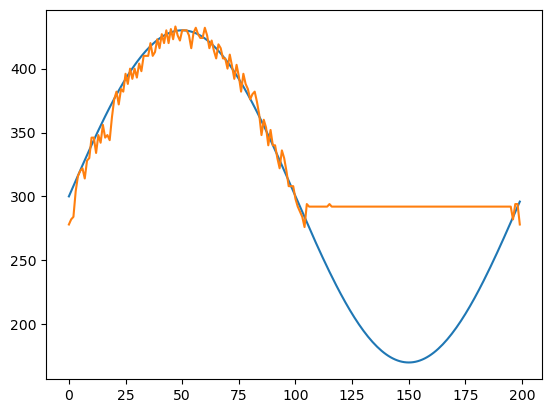

In [139]:
from adaptive_filter.cerebellum import AdaptiveFilterCerebellum

def NNwithAF(target_x, target_y, iter_num):

    target_x_coord = target_x
    target_y_coord = target_y
    number_of_iterations_for_convergence = 0
    max_iter = iter_num
    #TODO:Intialize your best neural network model and load the saved paramemeters
    NN_model = NN(n_feature=2,n_hidden1=100,n_hidden2=100, n_output=1)
    NN_model.load_state_dict(torch.load('best_nn_model.pth'))

    x_ref_vec = []
    x_act_vec = []

    ## TODO: AF initialization
    Ts = 1e-3
    n_inputs = 1
    n_outputs = 1
    n_bases = 20
    beta = 1e-4

    af = AdaptiveFilterCerebellum(Ts, n_inputs, n_outputs, n_bases, beta)

    robot_input = 0

    ## Simulation loop
    for i in range(max_iter):
       
        cam = ct.prepare_camera()
        img = ct.capture_image(cam)
        x,y = ct.locate(img,low_green, high_green)

        # cam_red = ct.prepare_camera()
        # img_red = ct.capture_image(cam)
        # x_red,y_red = ct.locate(img,low_red, high_red)

        x_ref = A * np.sin(2*np.pi * i/T) + 300
        # x_ref = 450
        y_ref = y

        x_ref = float(x_ref)
        y_ref = float(y_ref)

        print(i, x, x_ref)

        x_ref_vec.append(x_ref)
        x_act_vec.append(x)

        # print(x,y)
        robot_x_coord_in_image = x
        robot_y_coord_in_image = y
        x_coord_error = x_ref - robot_x_coord_in_image;
        y_coord_error = y_ref - robot_y_coord_in_image;
        
        ## TODO: Implement the CMAC controller into the loop
       
        af_out = af.step(robot_input, x_coord_error)
        # print(af_out)
        x_coord_error = x_coord_error +af_out
        
        #Here if the errors are less than twenty pixels we assume robot reaches the target. 
        # However you can choose any reasonable threshold value instead of 20.
        # if (np.abs(x_coord_error) < (1+x_prev*1.02) and np.abs(y_coord_error) < (1+y_coord_error*1.02)):
        #     print("number of iterations for convergence = ", number_of_iterations_for_convergence)
        #     break
        
        xy_input_nn_model = [x_coord_error,y_coord_error]
    
        #TODO: normalize the input to the Neural network model using meaning and variance of the training set inputs.
        normalize_xy_input_nn_model = (torch.tensor(xy_input_nn_model) - mean_of_train_input)/std_of_the_train_input
   
        prediction_for_Y_pos_increment = NN_model(normalize_xy_input_nn_model)
        # print(prediction_for_Y_pos_increment)
        #TODO: Get the current Y (angular) position/angle of the robot. you can use the api.getPos function of fable
        robot_current_Y_pos = api.getPos(1,moduleID)
        #Next Y angular position of the robot will be robot_Y_pos + prediction_for_Y_pos_increment
        robot_next_Y_pos = robot_current_Y_pos + prediction_for_Y_pos_increment
       
        robot_nn_and_af = robot_next_Y_pos
        robot_input = prediction_for_Y_pos_increment.detach().numpy()

        #TODO: Set the next position of the robot to (-90,robot_next_Y_pos) using the setPos function of the fable.
        api.setPos(-90,robot_nn_and_af,moduleID)
        api.sleep(0.3)
        number_of_iterations_for_convergence = number_of_iterations_for_convergence + 1
        

    return [x_ref_vec,x_act_vec]

[x_ref_vec,x_act_vec] = NNwithAF(0,0, 200)
plt.plot(np.arange(len(x_ref_vec)),x_ref_vec)
plt.plot(np.arange(len(x_act_vec)),x_act_vec)
plt.show()

In [ ]:
#TODO: Compare the number of iteration it takes for convergence in the control loop with 
# neural network only and with both CMAC and neural network.